## imports

In [1]:
import argparse
import icelakes
from icelakes.utilities import encedc, decedc
from icelakes.nsidc import download_granule, edc
from icelakes.detection import read_atl03 #, detect_lakes
from icelakes.detection import make_mframe_df, find_flat_lake_surfaces, get_densities_and_2nd_peaks,\
                               merge_lakes, check_lake_surroundings, calculate_remaining_densities, prnt

## parsing arguments from command line

In [2]:
parser = argparse.ArgumentParser(description='Test script to print some stats for a given ICESat-2 ATL03 granule.')
parser.add_argument('--granule', type=str, default='ATL03_20210715182907_03381203_005_01.h5',
                    help='The producer_id of the input ATL03 granule')
parser.add_argument('--polygon', type=str, default='geojsons/jakobshavn_small.geojson',
                    help='The file path of a geojson file for spatial subsetting')
parser.add_argument('--IS2datadir', type=str, default='IS2data',
                    help='The directory into which to download ICESat-2 granules')
parser.add_argument('--download_gtxs', type=str, default='all',
                    help='String value or list of gtx names to download, also accepts "all"')

# set arguments as class for now, to run in jupyter
if parser.prog == 'ipykernel_launcher.py':
    class Args:
        granule = 'ATL03_20210715182907_03381203_005_01.h5'
        polygon = 'geojsons/jakobshavn_small.geojson'
        IS2datadir =  'IS2data'
        download_gtxs = 'all'
    args=Args()
else:
    args = parser.parse_args()

In [3]:
# from icelakes.nsidc import shp2geojson
# shp2geojson('shapefiles/weird_shape_test.shp')

## download data from NSIDC

In [4]:
# # args.polygon = 'geojsons/jakobshavn_small.geojson'
# input_filename = download_granule(args.granule, args.download_gtxs, args.polygon, args.IS2datadir, decedc(edc().u), decedc(edc().p))

In [5]:
# just to not have to re-download nsidc data while testing
input_filename = 'IS2data/processed_ATL03_20210715182907_03381203_005_01.h5'

In [6]:
import os
import h5py
import datetime
import traceback
import pandas as pd
import numpy as np
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks
import matplotlib.pylab as plt
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from icelakes.utilities import convert_time_to_string
pd.set_option('mode.chained_assignment', 'raise')


##########################################################################################
def detect_lakes(photon_data, gtx, ancillary, polygon, verbose=False):

    # get the data frame for the gtx and aggregate info at major frame level
    df = photon_data[gtx]
    df_mframe = make_mframe_df(df)
    
    # get all the flat segments and select
    print('\n-----------------------------------------------------------------------------\n')
    print('PROCESSING GROUND TRACK: %s (%s)' % (gtx, ancillary['gtx_strength_dict'][gtx]))
    print('---> finding flat surfaces', end=' ')
    df_mframe = find_flat_lake_surfaces(df_mframe, df)
    print('(%i / %i were flat)' % (df_mframe.is_flat.sum(), df_mframe.is_flat.count()))
    df_selected = df_mframe[df_mframe.is_flat]
    
    # calculate densities and find second peaks (where surface is flat)
    print('---> calculating densities and looking for second peaks')
    get_densities_and_2nd_peaks(df, df_mframe, df_selected, gtx, ancillary, print_results=verbose)
    print('(%i / %i pass lake quality test)' % (df_mframe.lake_qual_pass.sum(), df_mframe.lake_qual_pass.count()))
    
    print('---> merging lake segments iteratively')
    df_lakes = merge_lakes(df_mframe, print_progress=verbose, debug=verbose)
    if df_lakes is None:
        return df_lakes, df_mframe, df
    prnt(df_lakes)
    
    print('---> checking lake edges and extending lakes if they match')
    df_lakes = check_lake_surroundings(df_mframe, df_lakes)
    prnt(df_lakes)
    
    print('---> calculating remaining photon densities')
    calculate_remaining_densities(df, df_mframe, df_lakes, gtx, ancillary)
    
    thelakes = []
    if df_lakes is not None:
        for i in range(len(df_lakes)):
            lakedata = df_lakes.iloc[i]
            thislake = melt_lake(lakedata.mframe_start, lakedata.mframe_end, lakedata.surf_elev)
            thislake.add_data(df, df_mframe, gtx, ancillary, polygon)
            thelakes.append(thislake)
    
    return thelakes


##########################################################################################
class melt_lake:
    def __init__(self, mframe_start, mframe_end, main_peak):
        self.mframe_start = int(mframe_start)
        self.mframe_end = int(mframe_end)
        self.main_peak = main_peak

    
    #-------------------------------------------------------------------------------------
    def add_data(self, df, df_mframe, gtx, ancillary, polygon):
        
        # useful metadata
        self.granule_id = ancillary['granule_id']
        self.rgt = ancillary['rgt']
        self.gtx = gtx
        self.polygon_filename = polygon
        self.polygon_name = polygon[polygon.rfind('/')+1 : polygon.find('.geojson')]
        self.beam_number = ancillary['gtx_beam_dict'][self.gtx]
        self.beam_strength = ancillary['gtx_strength_dict'][self.gtx]
        self.cycle_number = ancillary['cycle_number']
        self.sc_orient = ancillary['sc_orient']
        
        # add the data frames at the photon level and at the major frame level
        self.photon_data = df[(df['mframe'] >= self.mframe_start) & (df['mframe'] <= self.mframe_end)].copy()
        self.mframe_data = df_mframe[(df_mframe.index >= self.mframe_start) & (df_mframe.index <= self.mframe_end)].copy()
        self.date_time = convert_time_to_string(self.mframe_data['dt'].mean())
        self.photon_data.reset_index(inplace=True, drop=True)
        
        # reset the xatc values to start at zero
        min_xatc = self.photon_data.xatc.min()
        self.photon_data['xatc'] -= min_xatc
        self.mframe_data['xatc_min'] -= min_xatc
        self.mframe_data['xatc_max'] -= min_xatc
        self.mframe_data['xatc'] = (self.mframe_data['xatc_min'] + self.mframe_data['xatc_max']) / 2
        
        # compile the second returns in simple arrays
        h_2nds = np.array([v for l in list(self.mframe_data['h_2nd_returns'])[2:-2] for v in l])
        xatc_2nds = np.array([v for l in list(self.mframe_data['xatc_2nd_returns'])[2:-2] for v in l])
        prom_2nds = np.array([v for l in list(self.mframe_data['proms_2nd_returns'])[2:-2] for v in l])
        self.detection_2nd_returns = {'h':h_2nds, 'xatc':xatc_2nds - min_xatc, 'prom':prom_2nds}
        
        to_remove = ['has_densities', 'xatc_2nd_returns', 'proms_2nd_returns', 'h_2nd_returns']
        self.mframe_data.drop(columns=to_remove, inplace=True)
        
        # add general lat/lon info for the whole lake
        # self.detection_quality = np.sum(self.mframe_data['quality_summary']) / (len(self.mframe_data) - 4)
        self.lat_min = self.mframe_data['lat'].min()
        self.lat_max = self.mframe_data['lat'].max()
        self.lat = (self.mframe_data['lat'].min() + self.mframe_data['lat'].max()) / 2
        self.lat_str = '%.5f°N'%(self.lat) if self.lat>=0 else '%.5f°S'%(-self.lat)
        self.lon_min = self.mframe_data['lon'].min()
        self.lon_max = self.mframe_data['lon'].max()
        self.lon = (self.mframe_data['lon'].min() + self.mframe_data['lon'].max()) / 2
        self.lon_str = '%.5f°E'%(self.lon) if self.lon>=0 else '%.5f°W'%(-self.lon)
        
        # get the ice sheet and the melt season
        self.ice_sheet = 'GrIS' if self.lat>=0 else 'AIS'
        meltseason = 'XX'
        if self.ice_sheet=='GrIS':
            meltseason = self.date_time[:4]
        elif self.ice_sheet=='AIS':
            thismonth = int(self.date_time[5:7])
            thisyear = int(self.date_time[:4])
            if thismonth > 6:
                meltseason = str(thisyear) + '-' + str((thisyear+1)%100)
            elif thismonth <= 6:
                meltseason = str(thisyear-1) + '-' + str(thisyear%100)
        self.melt_season = meltseason
        
        # quick-look link to OpenAltimetry
        mptyp = 'arctic' if self.lat>=0 else 'antarctic'
        lake_oa_url = 'https://openaltimetry.org/data/icesat2/elevation?product=ATL03&zoom_level=7&tab=photon&'
        lake_oa_url += 'date={date}&minx={minx}&miny={miny}&maxx={maxx}&maxy={maxy}&tracks={track}&mapType={mptyp}&beams={beam_nr}'.format(
                date=self.date_time[:10], minx=self.lon_min, miny=self.lat_min, maxx=self.lon_max, maxy=self.lat_max,
                track=self.rgt, mptyp=mptyp, beam_nr=self.beam_number)
        self.oaurl = lake_oa_url

    #-------------------------------------------------------------------------------------
    def calculate_extent(self):
        
        return
    
    
    #-------------------------------------------------------------------------------------
    def calculate_detection_summary(self):
        
        return
    
        
    #-------------------------------------------------------------------------------------
    def plot_detected(self, fig_dir='figs', verbose=False, min_width=100, min_depth=1.5):
        
        lake_minh = np.min(self.detection_2nd_returns['h'])
        lake_max_depth = np.abs(self.main_peak - np.min(self.detection_2nd_returns['h']))
        lake_segment_length = np.abs(np.max(self.detection_2nd_returns['xatc']) - np.min(self.detection_2nd_returns['xatc']))
        lake_maxh = np.min((self.mframe_data['peak'].max(), self.main_peak+3*lake_max_depth))
        buffer_top = np.max((0.2*lake_max_depth, 1.0))
        buffer_bottom = np.max((0.3*lake_max_depth, 2.0))
        lake_minh_plot = lake_minh - buffer_bottom
        lake_maxh_plot = lake_maxh + buffer_top
        
        if (lake_max_depth > min_depth) & (lake_segment_length > min_width):
            fig, ax = plt.subplots(figsize=[9, 5], dpi=100)

            scatt = ax.scatter(self.photon_data.xatc, self.photon_data.h, 
                               s=3, c=self.photon_data.snr, alpha=1, edgecolors='none', cmap=cmc.lajolla, vmin=0, vmax=1)

            # plot surface elevation
            xmin, xmax = ax.get_xlim()
            ax.plot([xmin, xmax], [self.main_peak, self.main_peak], 'g-', lw=0.5)

            # plot mframe bounds
            ymin, ymax = ax.get_ylim()
            mframe_bounds_xatc = list(self.mframe_data['xatc_min']) + [self.mframe_data['xatc_max'].iloc[-1]]
            for xmframe in mframe_bounds_xatc:
                ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)

            dfpass = self.mframe_data[self.mframe_data['lake_qual_pass']]
            dfnopass = self.mframe_data[~self.mframe_data['lake_qual_pass']]
            ax.plot(dfpass.xatc, dfpass.peak, marker='o', mfc='g', mec='g', linestyle = 'None', ms=5)
            ax.plot(dfnopass.xatc, dfnopass.peak, marker='o', mfc='none', mec='r', linestyle = 'None', ms=3)

            for j, prom in enumerate(self.detection_2nd_returns['prom']):
                ax.plot(self.detection_2nd_returns['xatc'][j], self.detection_2nd_returns['h'][j], 
                        marker='o', mfc='none', mec='b', linestyle = 'None', ms=prom*4)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='4%', pad=0.05)
            fig.colorbar(scatt, cax=cax, orientation='vertical')

            ax.set_ylim((lake_minh_plot, lake_maxh_plot))
            ax.set_xlim((0.0, self.mframe_data.xatc_max.max()))

            ax.set_title('Lake at (%s, %s) on %s\nICESat-2 track %d %s (%s), cycle %d' % \
                         (self.lat_str, self.lon_str, self.date_time, self.rgt, self.gtx, self.beam_strength, 
                          self.cycle_number))
            ax.set_ylabel('elevation above geoid [m]')
            ax.set_xlabel('along-track distance [m]')

            # save figure
            if not os.path.exists(fig_dir): os.makedirs(fig_dir)
            epoch = self.mframe_data['dt'].mean() + datetime.datetime.timestamp(datetime.datetime(2018,1,1))
            dateid = datetime.datetime.fromtimestamp(epoch).strftime("%Y%m%d-%H%M%S")
            granid = self.granule_id[:-3]
            latid = '%dN'%(int(np.round(self.lat*1e5))) if self.lat>=0 else '%dS'%(-int(np.round(self.lat*1e5)))
            lonid = '%dE'%(int(np.round(self.lon*1e5))) if self.lon>=0 else '%dW'%(-int(np.round(self.lon*1e5)))
            figname = fig_dir + '/lake_%s_%s_%s_%s-%s.jpg' % (self.polygon_name, granid, self.gtx, latid, lonid)
            fig.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)
            plt.close(fig)
            
            return fig        

## read in the data

In [7]:
%%time
photon_data, bckgrd_data, ancillary = read_atl03(input_filename, geoid_h=True)
gtx_list = list(photon_data.keys())
print('  Ground Tracks to process: %s' % ', '.join(gtx_list))

  reading in IS2data/processed_ATL03_20210715182907_03381203_005_01.h5
  reading in beam: gt1l gt1r gt2l gt2r gt3l gt3r  --> done.
  Ground Tracks to process: gt1l, gt1r, gt2l, gt2r, gt3l, gt3r
CPU times: user 5.48 s, sys: 979 ms, total: 6.46 s
Wall time: 6.31 s


In [8]:
%%time
lake_list = []
for gtx in gtx_list:
    lake_list += detect_lakes(photon_data, gtx, ancillary, args.polygon, verbose=True)


-----------------------------------------------------------------------------

PROCESSING GROUND TRACK: gt1l (weak)
---> finding flat surfaces (10 / 666 were flat)
---> calculating densities and looking for second peaks
  mframe 765: h=1008.85m | flat=Yes | snrs= 317,   8,   9 | 2nds=  0% | range=0.00 align=0.00 strength=0.00 --> qual=0.00 | pass= No
  mframe 811: h= 969.31m | flat=Yes | snrs= 322,  10,   7 | 2nds=  0% | range=0.00 align=0.00 strength=0.00 --> qual=0.00 | pass= No
  mframe 812: h= 969.34m | flat=Yes | snrs= 327,   9,   8 | 2nds=  0% | range=0.00 align=0.00 strength=0.00 --> qual=0.00 | pass= No
  mframe 820: h= 972.79m | flat=Yes | snrs= 146,   6,   5 | 2nds= 46% | range=1.00 align=0.48 strength=0.32 --> qual=0.07 | pass=Yes
  mframe 821: h= 972.84m | flat=Yes | snrs= 194,   7,   5 | 2nds=  0% | range=0.00 align=0.00 strength=0.00 --> qual=0.00 | pass= No
  mframe 037: h= 932.94m | flat=Yes | snrs= 265,  10,   9 | 2nds=  0% | range=0.00 align=0.00 strength=0.00 --> qu

In [104]:
def get_surface_elevation(self, search_width=1.0, bin_h=0.005, smoothing=0.1):
    selector = (self.photon_data.h < (self.main_peak+search_width)) & (self.photon_data.h > (self.main_peak-search_width))
    heights = self.photon_data.h[selector]
    bins = np.arange(start=self.main_peak-search_width, stop=self.main_peak+search_width, step=bin_h)
    mid = bins[:-1] + 0.5 * bin_h
    hist = np.histogram(heights, bins=bins)
    window_size = int(smoothing/bin_h)
    hist_vals_smoothed = np.array(pd.Series(hist[0]).rolling(window_size,center=True,min_periods=1).mean())
    self.surface_elevation = mid[np.argmax(hist_vals_smoothed)]
    
    
def get_surface_extent(self, surf_width=0.4, abov_width=2.0, bin_width=1.0, smooth=31, max_ratio=0.3, min_length=100.0):
    if smooth%2 == 1: smooth += 1
    surf_selector = (self.photon_data.h > (self.surface_elevation-surf_width/2)) & (self.photon_data.h < (self.surface_elevation+surf_width/2))
    abov_selector = (self.photon_data.h > (self.surface_elevation+surf_width/2)) & (self.photon_data.h < (self.surface_elevation+surf_width/2+abov_width))
    totl_selector = (self.photon_data.h < (self.surface_elevation-surf_width/2)) | (self.photon_data.h > (self.surface_elevation+surf_width/2))
    df_surf = self.photon_data[surf_selector]
    df_abov = self.photon_data[abov_selector]
    df_totl = self.photon_data[totl_selector]
    bins = np.arange(start=self.photon_data.xatc.min(), stop=self.photon_data.xatc.max(), step=bin_width)
    mids = bins[:-1] + 0.5 * bin_width
    hist_surf = np.histogram(df_surf.xatc, bins=bins)
    hist_abov = np.histogram(df_abov.xatc, bins=bins)
    hist_totl = np.histogram(df_totl.xatc, bins=bins)
    max_all = binned_statistic(self.photon_data.xatc, self.photon_data.h, statistic='max', bins=bins)
    min_all = binned_statistic(self.photon_data.xatc, self.photon_data.h, statistic='min', bins=bins)
    surf_smooth = np.array(pd.Series(hist_surf[0]).rolling(smooth,center=True,min_periods=1).mean())
    abov_smooth = np.array(pd.Series(hist_abov[0]).rolling(smooth,center=True,min_periods=1).mean())
    totl_smooth = np.array(pd.Series(hist_totl[0]).rolling(smooth,center=True,min_periods=1).mean())
    maxs_smooth = np.array(pd.Series(max_all[0]).rolling(smooth,center=True,min_periods=1).max())
    mins_smooth = np.array(pd.Series(min_all[0]).rolling(smooth,center=True,min_periods=1).min())
    dens_surf = surf_smooth / (surf_width*bin_width)
    dens_abov = abov_smooth / (abov_width*bin_width)
    dens_totl = totl_smooth / ((maxs_smooth-mins_smooth-surf_width)*bin_width)
    dens_surf[dens_surf == 0] = 1e-20
    dens_ratio_abov = dens_abov / dens_surf
    dens_ratio_totl = dens_totl / dens_surf
    dens_ratio_abov[dens_ratio_abov>1] = 1
    dens_ratio_totl[dens_ratio_totl>1] = 1
    dens_eval = np.max(np.vstack((dens_ratio_abov,dens_ratio_totl)), axis=0)
    surf_possible = dens_eval < max_ratio
    surf_possible[(mids<250) | (mids>(np.max(mids)-250))] = False # because we added two extra major frames on each side

    # get surface segments that are continuous for longer than x meters
    current_list = []
    surface_segs = []
    i = 0
    while i < len(surf_possible):
        if surf_possible[i]:
            current_list.append(i)
        else:
            if (len(current_list) * bin_width) > min_length:
                surface_segs.append([mids[current_list[0]], mids[current_list[-1]]])
            current_list = []
        i += 1 
    self.surface_extent_detection = surface_segs

#-------------------------------------------------------------------------------------
def plot_detected(self, fig_dir='figs', verbose=False, min_width=100, min_depth=1.5, print_mframe_info=True):
    
    from matplotlib.patches import Rectangle
    
    lake_minh = np.min(self.detection_2nd_returns['h'])
    lake_max_depth = np.abs(self.main_peak - np.min(self.detection_2nd_returns['h']))
    lake_segment_length = np.abs(np.max(self.detection_2nd_returns['xatc']) - np.min(self.detection_2nd_returns['xatc']))
    lake_maxh = np.min((self.mframe_data['peak'].max(), self.main_peak+3*lake_max_depth))
    buffer_bottom = np.max((0.5*lake_max_depth, 2.0))
    lake_minh_plot = lake_minh - buffer_bottom
    buffer_top = (lake_maxh - lake_minh_plot) * 0.5
    # buffer_top = np.max((0.5*lake_max_depth, 2.0))
    lake_maxh_plot = lake_maxh + buffer_top
    ylms = (lake_minh_plot, lake_maxh_plot)
    xlms = (0.0, self.mframe_data.xatc_max.max())

    if (lake_max_depth > min_depth) & (lake_segment_length > min_width):
        fig, ax = plt.subplots(figsize=[9, 5], dpi=100)
        
        # plot the ATL03 photon data
        scatt = ax.scatter(self.photon_data.xatc, self.photon_data.h,s=5, c=self.photon_data.snr, alpha=1, 
                           edgecolors='none', cmap=cmc.lajolla, vmin=0, vmax=1)
        p_scatt = ax.scatter([-9999]*4, [-9999]*4, s=15, c=[0.0,0.25,0.75,1.0], alpha=1, edgecolors='none', cmap=cmc.lajolla, 
                             vmin=0, vmax=1, label='ATL03 photons')
        # ax.scatter(self.photon_data.xatc, self.photon_data.h, s=3, c='k', alpha=1, edgecolors='none')

        # plot surface elevation
        for xtent in self.surface_extent_detection:
            p_surf_elev, = ax.plot(xtent, [self.surface_elevation, self.surface_elevation], 'g-', lw=3, label='lake surface')
            
        # plot the second returns from detection
        for j, prom in enumerate(self.detection_2nd_returns['prom']):
            ax.plot(self.detection_2nd_returns['xatc'][j], self.detection_2nd_returns['h'][j], 
                                    marker='o', mfc='none', mec='b', linestyle = 'None', ms=prom*12)
        p_2nd_return, = ax.plot(-9999, -9999, marker='o', mfc='none', mec='b', ls='None', ms=3, label='second returns')
        
        # plot mframe bounds
        ymin, ymax = ax.get_ylim()
        mframe_bounds_xatc = list(self.mframe_data['xatc_min']) + [self.mframe_data['xatc_max'].iloc[-1]]
        for xmframe in mframe_bounds_xatc:
            ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)
        
        # visualize which segments initially passed
        for i, passing in enumerate(self.mframe_data['lake_qual_pass']):
            mf = self.mframe_data.iloc[i]
            if passing:
                xy = (mf.xatc_min, ylms[0])
                width = mf.xatc_max - mf.xatc_min
                height = ylms[1] - ylms[0]
                rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=(0,0,1,0.1), zorder=-1000, label='major frame passed lake check')
                p_passed = ax.add_patch(rct)
            p_mfpeak, = ax.plot((mf.xatc_min,mf.xatc_max), (mf.peak,mf.peak),'k-',lw=0.5, label='major frame peak')
        
        # add a legend
        hdls = [p_scatt, p_surf_elev, p_2nd_return, p_mfpeak, p_passed]
        ax.legend(handles=hdls, loc='lower left', fontsize=7, scatterpoints=4)
        
        # add the colorbar 
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='4%', pad=0.05)
        cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
        cbar.ax.get_yaxis().set_ticks([])
        for j, lab in enumerate([0.2, 0.4, 0.6, 0.8]):
            cbar.ax.text(.5, lab, '%.1f'%lab, ha='center', va='center', fontweight='black')
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel('photon density', rotation=270, fontsize=8)
        
        # add labels and description in title
        txt  = 'ICESat-2 Lake Detection: %s, ' % ('Greenland Ice Sheet' if self.lat>=0 else 'Antarctic Ice Sheet')
        txt += '%s Melt Season' % self.melt_season
        fig.suptitle(txt, y=0.95, fontsize=14)
        
        txt  = 'location: %s, %s (area: %s) | ' % (self.lat_str, self.lon_str, self.polygon_name)
        txt += 'time: %s UTC | surface elevation: %.2f m\n' % (self.date_time, self.surface_elevation)
        txt += 'RGT %s %s cycle %i | ' % (self.rgt, self.gtx.upper(), self.cycle_number)
        txt += 'beam %i (%s, %s spacecraft orientation) | ' % (self.beam_number, self.beam_strength, self.sc_orient)
        txt += 'granule ID: %s' % self.granule_id
        ax.set_title(txt, fontsize=8)

        ax.set_ylabel('elevation above geoid [m]',fontsize=8)
        ax.set_xlabel('along-track distance [m]',fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        
        # set limits
        ax.set_ylim(ylms)
        ax.set_xlim(xlms)
        fig.tight_layout()
        
        # add mframe info text
        if print_mframe_info:
            for i,loc in enumerate(self.mframe_data['xatc_min']):
                mf = self.mframe_data.iloc[i]
                txt  = 'mframe: %i\n' % (mf.name%1000)
                txt += 'photons: %i\n' % mf.n_phot
                txt += 'peak: %.2f\n' % mf.peak
                txt += 'flat: %s\n' % ('Yes.' if mf.is_flat else 'No.')
                txt += 'SNR surf: %i\n' % np.round(mf.snr_surf)
                txt += 'SNR up: %i\n' % np.round(mf.snr_upper)
                txt += 'SNR low: %i\n' % np.round(mf.snr_lower)
                txt += '2nds: %i%%\n' % np.round(mf.ratio_2nd_returns*100)
                txt += '2nds strength: %.2f\n' % mf.quality_secondreturns
                txt += '2nds number: %.2f\n' % mf.length_penalty
                txt += '2nds spread: %.2f\n' % mf.range_penalty
                txt += '2nds align: %.2f\n' % mf.alignment_penalty
                txt += '2nds quality: %.2f\n' % mf.quality_summary
                txt += 'pass: %s' % ('Yes.' if mf.lake_qual_pass else 'No.')
                trans = ax.get_xaxis_transform()
                bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
                ax.text(loc+5, 0.99, txt, transform=trans, fontsize=4, va='top', bbox=bbox)

        # save figure
        if not os.path.exists(fig_dir): os.makedirs(fig_dir)
        epoch = self.mframe_data['dt'].mean() + datetime.datetime.timestamp(datetime.datetime(2018,1,1))
        dateid = datetime.datetime.fromtimestamp(epoch).strftime("%Y%m%d-%H%M%S")
        granid = self.granule_id[:-3]
        latid = '%dN'%(int(np.round(self.lat*1e5))) if self.lat>=0 else '%dS'%(-int(np.round(self.lat*1e5)))
        lonid = '%dE'%(int(np.round(self.lon*1e5))) if self.lon>=0 else '%dW'%(-int(np.round(self.lon*1e5)))
        figname = fig_dir + '/lake_%s_%s_%s_%s-%s.jpg' % (self.polygon_name, granid, self.gtx, latid, lonid)
        fig.patch.set_facecolor('white')
        fig.tight_layout()
        fig.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close(fig)

        return fig

In [105]:
# lake.mframe_data

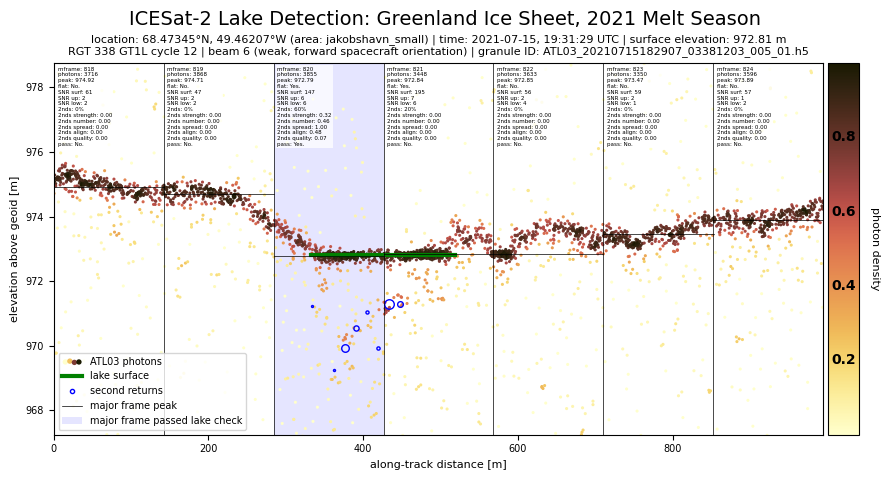

https://openaltimetry.org/data/icesat2/elevation?product=ATL03&zoom_level=7&tab=photon&date=2021-07-15&minx=-49.46331815728235&miny=68.46965074883364&maxx=-49.46082051773267&maxy=68.47723961601051&tracks=338&mapType=arctic&beams=6



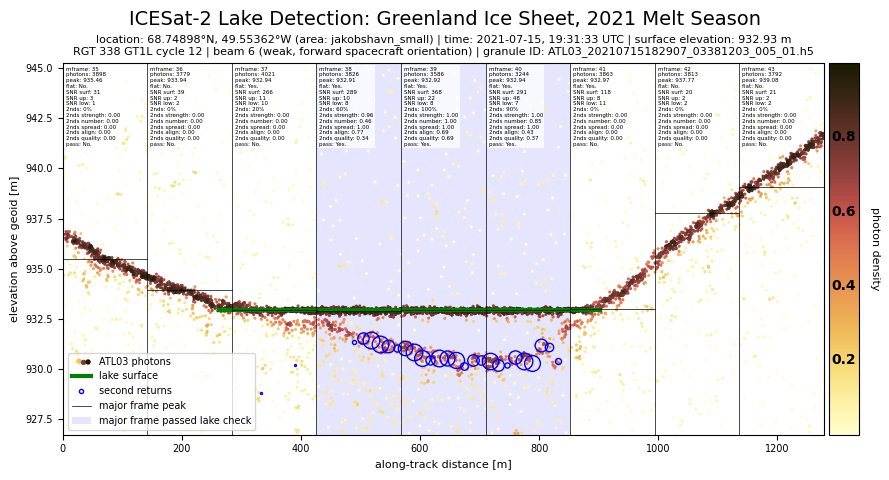

https://openaltimetry.org/data/icesat2/elevation?product=ATL03&zoom_level=7&tab=photon&date=2021-07-15&minx=-49.55531398255523&miny=68.7439249376317&maxx=-49.551930343457194&maxy=68.75403208221643&tracks=338&mapType=arctic&beams=6



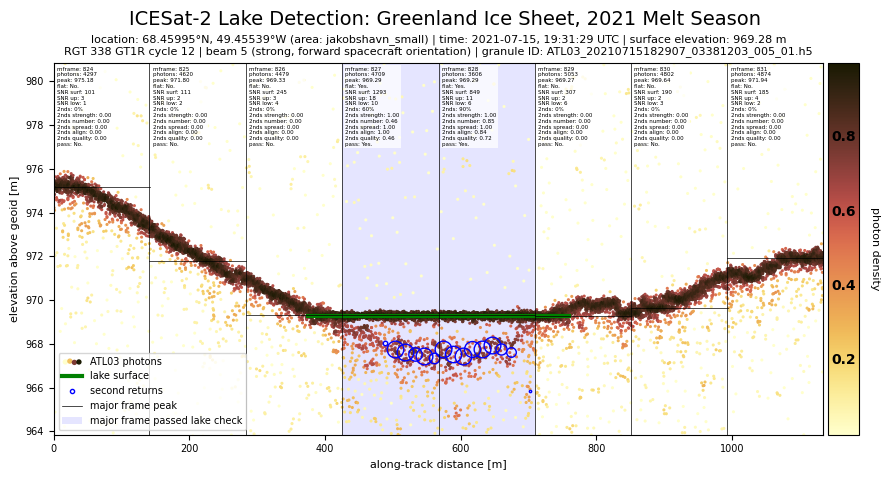

https://openaltimetry.org/data/icesat2/elevation?product=ATL03&zoom_level=7&tab=photon&date=2021-07-15&minx=-49.45684458736263&miny=68.45552736205472&maxx=-49.453940408133505&maxy=68.46436923503762&tracks=338&mapType=arctic&beams=5



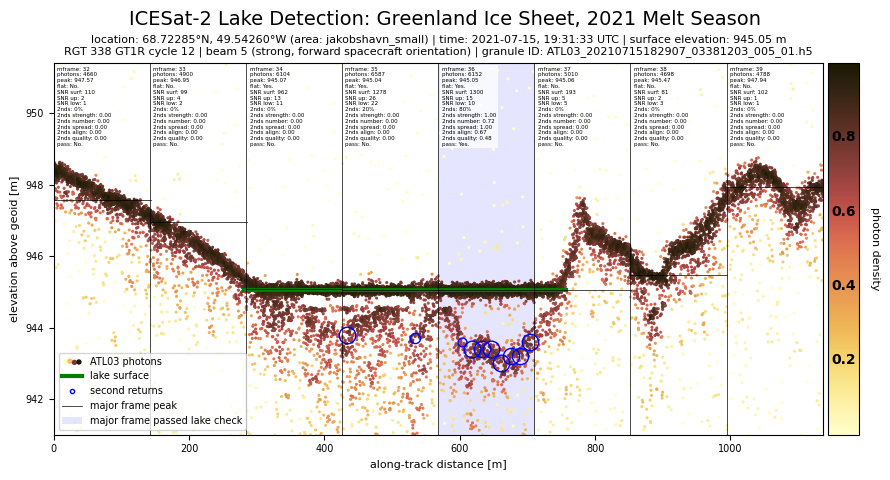

https://openaltimetry.org/data/icesat2/elevation?product=ATL03&zoom_level=7&tab=photon&date=2021-07-15&minx=-49.54408501391505&miny=68.71841840152727&maxx=-49.54110599425624&maxy=68.72728067653756&tracks=338&mapType=arctic&beams=5



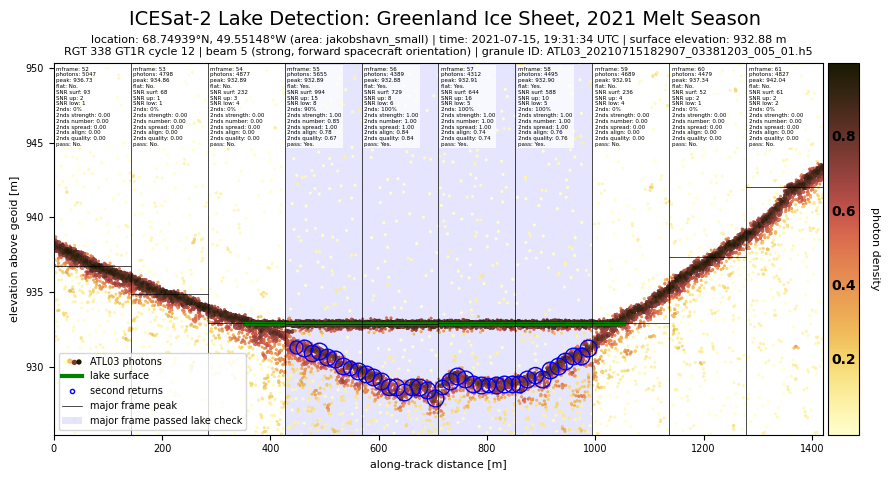

https://openaltimetry.org/data/icesat2/elevation?product=ATL03&zoom_level=7&tab=photon&date=2021-07-15&minx=-49.553393460736764&miny=68.74369704322083&maxx=-49.54956874815042&maxy=68.75508002420557&tracks=338&mapType=arctic&beams=5



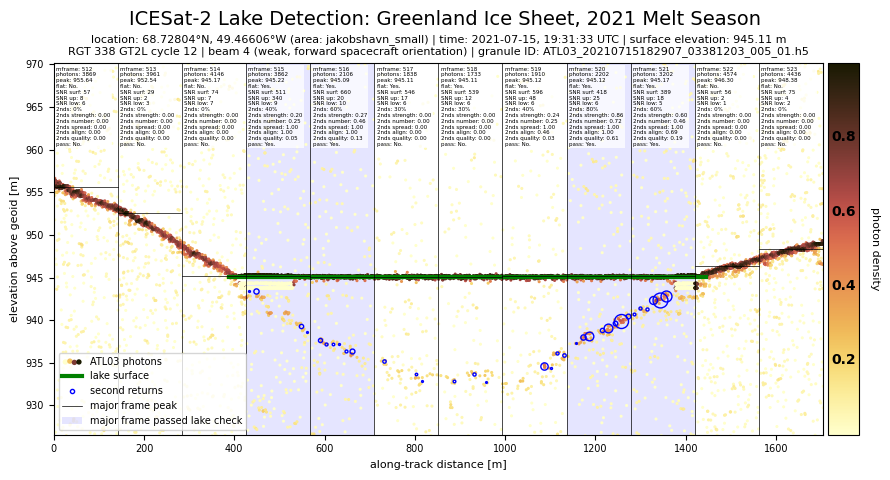

https://openaltimetry.org/data/icesat2/elevation?product=ATL03&zoom_level=7&tab=photon&date=2021-07-15&minx=-49.468360107721246&miny=68.72108220089257&maxx=-49.46375929103989&maxy=68.73499728798288&tracks=338&mapType=arctic&beams=4



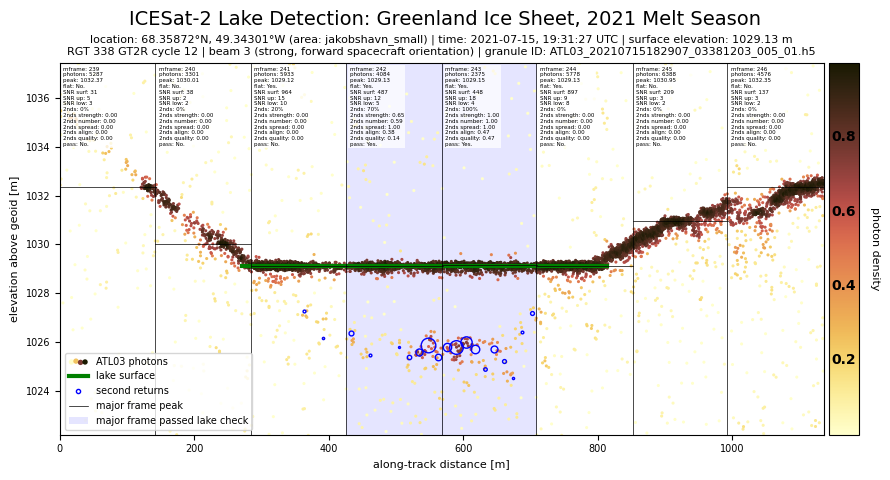

https://openaltimetry.org/data/icesat2/elevation?product=ATL03&zoom_level=7&tab=photon&date=2021-07-15&minx=-49.34443268175931&miny=68.3542854439997&maxx=-49.341584493637804&maxy=68.36316131466423&tracks=338&mapType=arctic&beams=3



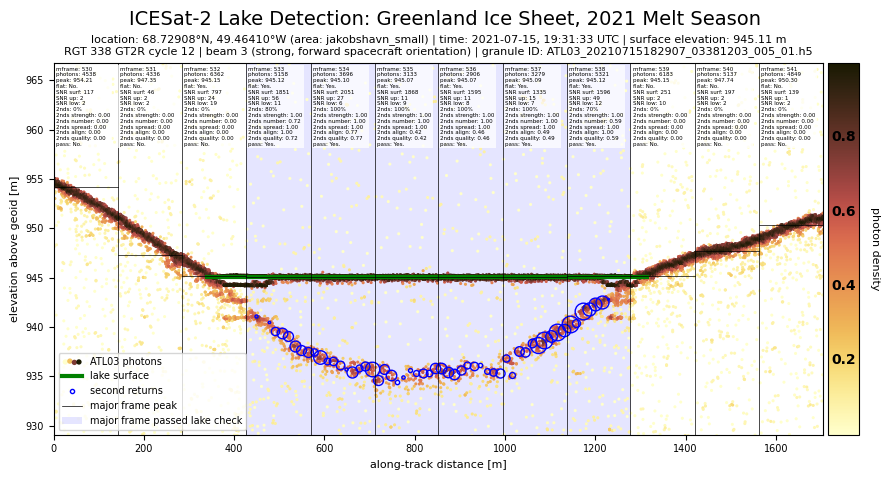

https://openaltimetry.org/data/icesat2/elevation?product=ATL03&zoom_level=7&tab=photon&date=2021-07-15&minx=-49.46641977113919&miny=68.72209644850379&maxx=-49.461774754106855&maxy=68.73605748234804&tracks=338&mapType=arctic&beams=3



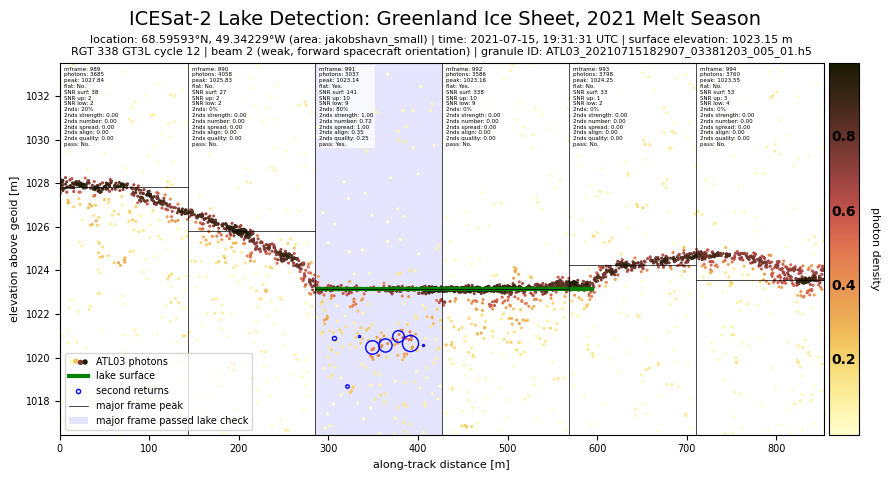

https://openaltimetry.org/data/icesat2/elevation?product=ATL03&zoom_level=7&tab=photon&date=2021-07-15&minx=-49.343320832670784&miny=68.59277499147669&maxx=-49.341267050563765&maxy=68.59908471577465&tracks=338&mapType=arctic&beams=2



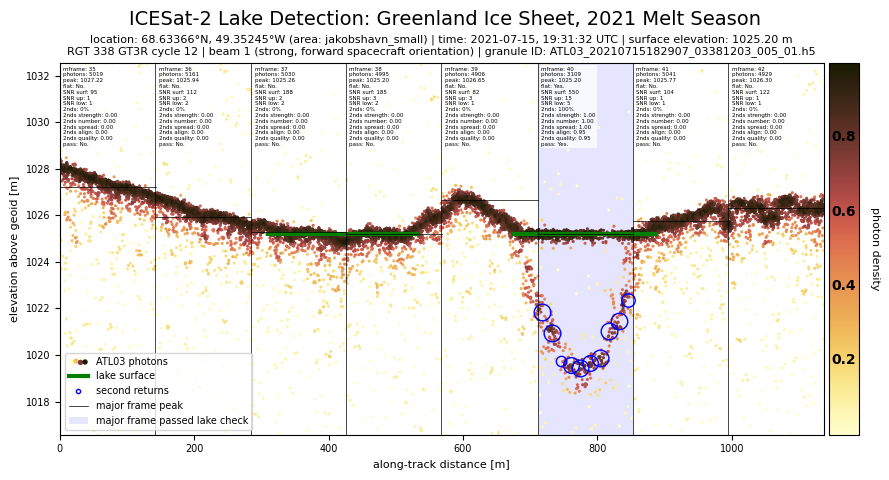

https://openaltimetry.org/data/icesat2/elevation?product=ATL03&zoom_level=7&tab=photon&date=2021-07-15&minx=-49.353888601648634&miny=68.62923769642664&maxx=-49.351008134819864&maxy=68.63808934087419&tracks=338&mapType=arctic&beams=1



In [106]:
from IPython.display import Image, display
for lake in lake_list:
    get_surface_elevation(lake)
    get_surface_extent(lake)
    fig = plot_detected(lake, min_width=0.0, min_depth=0.0)
    display(fig)
    print(lake.oaurl, end='\n\n')

In [ ]:
import pickle

mylake = lake_list[10]
get_surface_elevation(mylake)
print(mylake.surface_elevation)
print(mylake.main_peak)
abov, totl, mids = get_surface_extent(mylake)

with open('denss.pkl', 'wb') as f:
    pickle.dump([abov, totl, mids, mylake.photon_data, mylake.surface_elevation], f)

In [ ]:
fig, ax = 

In [ ]:
vars(mylake)

In [ ]:
# thelakes = []
# gtx = 'gt2l'
# if df_lakes is not None:
#     for i in range(len(df_lakes)):
#         lakedata = df_lakes.iloc[i]
#         thislake = melt_lake(lakedata.mframe_start, lakedata.mframe_end, lakedata.surf_elev)
#         thislake.add_data(df, df_mframe, gtx, ancillary, args.polygon)
#         thelakes.append(thislake)

In [ ]:
# %%time
# for gtx in gtx_list:
#     df_lakes, df_mframe, df = detect_lakes(photon_data, gtx, ancillary, args.polygon, verbose=True)

In [ ]:
# TODO
# # 2nds strength max 3
# # flatness total SNR to 150
# # ignore segments with just 2 2nd returns
# # increase spread penalty
# filter out specular returns on strong beams (or all)
# add second returns even if quality not passing
# show only second returns that are under the surface extent

In [ ]:
import os
import zipfile
filelist = ['figs/'+f for f in os.listdir('figs/') if os.path.isfile(os.path.join('figs/', f))]
ZipFile = zipfile.ZipFile("zip_testing.zip", "w" )
for file in filelist:
    ZipFile.write(file, compress_type=zipfile.ZIP_DEFLATED)
ZipFile.close()

In [ ]:
ancillary